In [1]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-fpqxl99e/pafy_4686a92131584df08f3bbc1432692886
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-fpqxl99e/pafy_4686a92131584df08f3bbc1432692886


In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import glob

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
#DATASET_DIR = "/content/drive/MyDrive/frames_ravdess_label"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["neutral", "calm", "happy", "sad","angry","fearful"]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import joblib
features = joblib.load('/content/drive/My Drive/features_ravdess/data_set/features_data')
labels = joblib.load('/content/drive/MyDrive/features_ravdess/data_set/labels')
video_files_paths = joblib.load('/content/drive/My Drive/features_ravdess/data_set/video_path')

In [7]:
features = np.asarray(features)
labels = np.array(labels)  

In [8]:
features.shape

(2067, 30, 64, 64, 3)

In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.10, shuffle = True,
                                                                            random_state = seed_constant)

In [11]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
   
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.1)))
    
    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(64))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [12]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 16, 16, 16)   0

In [13]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback])

Epoch 1/100
210/210 [==============================] - 24s 31ms/step - loss: 1.5577 - accuracy: 0.3602 - val_loss: 2.3831 - val_accuracy: 0.1398
Epoch 2/100
210/210 [==============================] - 5s 23ms/step - loss: 1.1669 - accuracy: 0.5096 - val_loss: 1.8737 - val_accuracy: 0.2581
Epoch 3/100
210/210 [==============================] - 5s 23ms/step - loss: 1.0192 - accuracy: 0.5866 - val_loss: 1.0126 - val_accuracy: 0.6183
Epoch 4/100
210/210 [==============================] - 5s 23ms/step - loss: 0.8885 - accuracy: 0.6523 - val_loss: 1.4919 - val_accuracy: 0.4570
Epoch 5/100
210/210 [==============================] - 5s 23ms/step - loss: 0.8165 - accuracy: 0.6780 - val_loss: 0.7752 - val_accuracy: 0.7043
Epoch 6/100
210/210 [==============================] - 5s 23ms/step - loss: 0.7341 - accuracy: 0.7115 - val_loss: 0.7220 - val_accuracy: 0.7151
Epoch 7/100
210/210 [==============================] - 5s 23ms/step - loss: 0.6235 - accuracy: 0.7640 - val_loss: 0.9515 - val_accuracy

In [14]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 [==============================] - 0s 35ms/step - loss: 0.7363 - accuracy: 0.8261


In [15]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'landmark3_lr=0.001___Accuracy_{model_evaluation_accuracy}___Loss_{model_evaluation_loss}.h5'

# Save the Model.
#LRCN_model.save('/content/drive/My Drive/marwa/saved_models/lrcn/'+model_file_name)

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

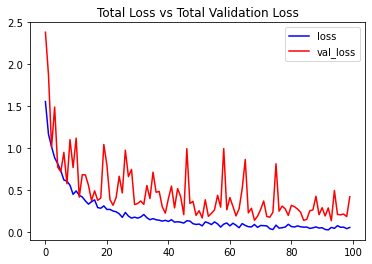

In [17]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

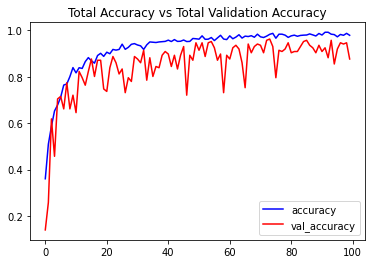

In [18]:

# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
predictions =  LRCN_model.predict(features_test)
predictions

array([[6.8946213e-01, 2.7549130e-04, 1.7547564e-04, 2.3897111e-01,
        3.9142412e-03, 6.7201495e-02],
       [3.4235645e-06, 1.3703620e-04, 3.1310232e-05, 2.0231130e-04,
        2.4646536e-02, 9.7497934e-01],
       [1.2106725e-06, 2.3569639e-05, 9.9992824e-01, 3.6635163e-06,
        3.4987683e-05, 8.2949891e-06],
       ...,
       [2.2230513e-05, 7.9587902e-05, 3.8414486e-04, 1.5707428e-03,
        8.5136138e-02, 9.1280711e-01],
       [6.0443053e-05, 8.5932988e-06, 5.4024775e-05, 1.0335067e-03,
        3.4579897e-01, 6.5304440e-01],
       [2.8952025e-04, 6.8866128e-01, 3.0865157e-01, 8.3607410e-05,
        1.5259658e-04, 2.1613345e-03]], dtype=float32)

In [20]:
preds=predictions.argmax(axis=1)
preds

array([0, 5, 2, 3, 5, 2, 5, 1, 4, 5, 5, 1, 4, 0, 4, 5, 4, 5, 1, 1, 5, 2,
       0, 2, 2, 5, 5, 5, 5, 5, 5, 4, 5, 0, 2, 2, 4, 1, 5, 4, 2, 2, 1, 5,
       2, 2, 5, 5, 5, 5, 4, 2, 1, 3, 3, 0, 5, 0, 2, 5, 4, 4, 5, 3, 1, 3,
       2, 0, 5, 1, 1, 2, 5, 5, 5, 4, 0, 3, 4, 4, 5, 4, 5, 0, 5, 5, 2, 5,
       3, 5, 5, 1, 0, 1, 5, 5, 1, 2, 5, 3, 4, 3, 0, 5, 4, 3, 2, 1, 4, 1,
       5, 2, 0, 1, 4, 0, 4, 1, 1, 3, 1, 5, 1, 5, 1, 2, 3, 2, 5, 1, 2, 0,
       1, 5, 1, 0, 5, 5, 1, 1, 2, 2, 2, 3, 2, 2, 3, 5, 0, 3, 2, 3, 5, 3,
       1, 2, 1, 5, 3, 0, 1, 3, 3, 2, 4, 1, 3, 3, 5, 4, 4, 3, 1, 5, 3, 1,
       5, 1, 4, 5, 4, 0, 3, 5, 3, 3, 1, 3, 3, 4, 1, 4, 3, 3, 4, 2, 3, 1,
       4, 5, 3, 2, 5, 2, 5, 5, 1])

In [21]:
new_preds = preds.astype(int).flatten()
new_preds

array([0, 5, 2, 3, 5, 2, 5, 1, 4, 5, 5, 1, 4, 0, 4, 5, 4, 5, 1, 1, 5, 2,
       0, 2, 2, 5, 5, 5, 5, 5, 5, 4, 5, 0, 2, 2, 4, 1, 5, 4, 2, 2, 1, 5,
       2, 2, 5, 5, 5, 5, 4, 2, 1, 3, 3, 0, 5, 0, 2, 5, 4, 4, 5, 3, 1, 3,
       2, 0, 5, 1, 1, 2, 5, 5, 5, 4, 0, 3, 4, 4, 5, 4, 5, 0, 5, 5, 2, 5,
       3, 5, 5, 1, 0, 1, 5, 5, 1, 2, 5, 3, 4, 3, 0, 5, 4, 3, 2, 1, 4, 1,
       5, 2, 0, 1, 4, 0, 4, 1, 1, 3, 1, 5, 1, 5, 1, 2, 3, 2, 5, 1, 2, 0,
       1, 5, 1, 0, 5, 5, 1, 1, 2, 2, 2, 3, 2, 2, 3, 5, 0, 3, 2, 3, 5, 3,
       1, 2, 1, 5, 3, 0, 1, 3, 3, 2, 4, 1, 3, 3, 5, 4, 4, 3, 1, 5, 3, 1,
       5, 1, 4, 5, 4, 0, 3, 5, 3, 3, 1, 3, 3, 4, 1, 4, 3, 3, 4, 2, 3, 1,
       4, 5, 3, 2, 5, 2, 5, 5, 1])

              precision    recall  f1-score   support

           0       0.94      0.63      0.76        27
           1       0.95      0.80      0.86        44
           2       0.88      0.97      0.92        30
           3       0.76      0.74      0.75        34
           4       1.00      0.82      0.90        34
           5       0.64      0.97      0.77        38

    accuracy                           0.83       207
   macro avg       0.86      0.82      0.83       207
weighted avg       0.86      0.83      0.83       207

----accuracy score 82.6086956521739 ----


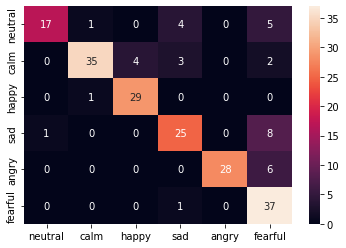

In [22]:

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
new_labels=np.argmax(labels_test, axis=1)
print(classification_report(new_labels,new_preds))

acc = float(accuracy_score(new_labels,new_preds))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(new_labels,new_preds)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral','calm', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()